<a href="https://colab.research.google.com/github/morganmcg1/reformer-fastai/blob/main/exploration/init_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip install -Uqq fastai einops datasets

In [2]:
from fastai.text.all import *
import datasets
from datasets import load_dataset
import six

In [3]:
dataset = load_dataset('tiny_shakespeare')

Using custom data configuration default
Reusing dataset tiny_shakespeare (/root/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/da11b9a200ca715af415094b34d5c956170f184cb3a58d7789680cf81bede955)


In [4]:
train_ds = dataset['train']

In [5]:
def splitlines(sample):
    return {'line':[*sample['text'][0].split('\n')]}

In [6]:
train_ds = train_ds.map(splitlines, batched=True, remove_columns=['text'])

Loading cached processed dataset at /root/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/da11b9a200ca715af415094b34d5c956170f184cb3a58d7789680cf81bede955/cache-a677cb7a72f76126.arrow


In [7]:
train_ds = train_ds.filter(lambda x: x['line'] != '')

Loading cached processed dataset at /root/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/da11b9a200ca715af415094b34d5c956170f184cb3a58d7789680cf81bede955/cache-5d990099acc0cb8c.arrow


In [8]:
train_ds[:10]

OrderedDict([('line',
              ['First Citizen:',
               'Before we proceed any further, hear me speak.',
               'All:',
               'Speak, speak.',
               'First Citizen:',
               'You are all resolved rather to die than to famish?',
               'All:',
               'Resolved. resolved.',
               'First Citizen:',
               'First, you know Caius Marcius is chief enemy to the people.'])])

In [9]:
df = train_ds.data.to_pandas()
df.head()

,line
0,First Citizen:
1,"Before we proceed any further, hear me speak."
2,All:
3,"Speak, speak."
4,First Citizen:


In [10]:
class ByteTextTokenizer(Transform):
    """
        Encodes each byte to an id. For 8-bit strings only.
        Credit: https://github.com/tensorflow/tensor2tensor/blob/5f9dd2db6d7797162e53adf152310ed13e9fc711/tensor2tensor/data_generators/text_encoder.py#L176
    """
    def __init__(self, is_lm=True, add_bos=False, add_eos=False):
        self.ls_lm = is_lm
        self.add_bos, self.add_eos = add_bos, add_eos
        self.pad_token, self.eos_token, self.bos_token = '<pad>', '<eos>', '<bos>',
        self.pad_token_id, self.eos_token_id, self.bos_token_id = 0,1,2
        self.reserved_toks = [self.pad_token, self.eos_token, self.bos_token]  ## self.bos_token_id 
        self.reserved_tokens_bytes = [bytes(rtok, 'ascii') for rtok in self.reserved_toks]
        self.numres = len(self.reserved_toks)
        self.int2byte = six.int2byte

    @typedispatch
    def __call__(self, o:list, **kwargs):
        out = [c + self.numres for s in o for c in s.encode("utf-8")]
        if self.add_bos: out = [self.bos_token_id] + out
        if self.add_eos: out =  out + [self.eos_token_id]
        if self.ls_lm:return LMTensorText(out)
        else: return TensorText(out) 
        
    @typedispatch
    def __call__(self, o:str, **kwargs):
        out = [c + self.numres for c in o.encode("utf-8")]
        if self.add_bos: out = [self.bos_token_id] + out
        if self.add_eos: out =  out + [self.eos_token_id]
        if self.ls_lm:return LMTensorText(out)
        else: return TensorText(out) 
    
    def encodes(self,o):
        return self.__call__(o)
    
    def decodes(self, o:tuple):
        decoded_ids = ()
        for i in o:
            tmp_ls=[]
            for id_ in i:
                if 0 <= id_ < self.numres: tmp_ls.append(self.reserved_tokens_bytes[int(id_)])
                else: tmp_ls.append(self.int2byte(id_ - self.numres))
            decoded_ids = decoded_ids + (b"".join(tmp_ls).decode("utf-8", "replace"),)
        return TitledStr(decoded_ids)
    
    def decodes(self, o:list):
        decoded_ids = []
        for id_ in o:
            if 0 <= id_ < self.numres: decoded_ids.append(self.reserved_tokens_bytes[int(id_)])
            else: decoded_ids.append(self.int2byte(id_ - self.numres))
        return TitledStr(b"".join(decoded_ids).decode("utf-8", "replace"))
    
    def decodes(self, o:TensorText):
        return self.decodes(o.tolist())
    
    def decodes(self, o:LMTensorText):
        return self.decodes(o.tolist())
    
    @property
    def vocab_size(self): return 2**8 + self.numres

In [11]:
bte = ByteTextTokenizer(is_lm=True, add_bos=True, add_eos=True)

In [12]:
@patch
def create_item(self:LMDataLoader, seq):
    if seq>=self.n: raise IndexError
    sl = self.last_len if seq//self.bs==self.n_batches-1 else self.seq_len
    st = (seq%self.bs)*self.bl + (seq//self.bs)*self.seq_len
    txt = self.chunks[st : st+sl+1]    
    return LMTensorText(txt[:-1]),txt[1:]
    # return LMTensorText(txt[:-1].tolist()+[1]), LMTensorText(txt[1:].tolist()+[1])   ## ADD EOS TOKEN

In [13]:
cut = int(len(df)*0.8)
splits = range_of(df)[:cut], range_of(df[cut:])

In [14]:
tfms = [attrgetter("line"), bte]
dsets = Datasets(df, [tfms, tfms], splits=splits, dl_type=LMDataLoader)

In [15]:
dsets[0]

(LMTensorText([  2,  73, 108, 117, 118, 119,  35,  70, 108, 119, 108, 125, 104, 113,
          61,   1]),
 LMTensorText([  2,  73, 108, 117, 118, 119,  35,  70, 108, 119, 108, 125, 104, 113,
          61,   1]))

In [16]:
bte.decode(_[0])

'<bos>First Citizen:<eos>'

In [17]:
bs,sl = 32,128
pad_seq2seq = partial(pad_input, pad_idx=bte.pad_token_id, pad_fields=[0,1])

dls = dsets.dataloaders(bs=bs, seq_len=sl, before_batch=pad_seq2seq, device=torch.device('cuda'))

In [18]:
dls.show_batch(max_n=2)

,text,text_
0,"<bos>Roman:<eos><bos>CAMILLO:<eos><bos>For this will out, and here I must not stay.<eos><bos>Madam, he hath not slept tonight; commanded<eos><bos>About what?<eos><bos>man.<eos>","Roman:<eos><bos>CAMILLO:<eos><bos>For this will out, and here I must not stay.<eos><bos>Madam, he hath not slept tonight; commanded<eos><bos>About what?<eos><bos>man.<eos><bos>"
1,"s she hangs upon the cheek of night<eos><bos>TYBALT:<eos><bos>CORIOLANUS:<eos><bos>Call for some men of sound direction<eos><bos>And die, ere men can say, God s","she hangs upon the cheek of night<eos><bos>TYBALT:<eos><bos>CORIOLANUS:<eos><bos>Call for some men of sound direction<eos><bos>And die, ere men can say, God sa"


In [19]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([32, 128]), torch.Size([32, 128]))

In [20]:
!wget https://raw.githubusercontent.com/morganmcg1/reformer-fastai/main/basic_transformer.py

--2020-11-19 21:17:06--  https://raw.githubusercontent.com/morganmcg1/reformer-fastai/main/basic_transformer.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17403 (17K) [text/plain]
Saving to: ‘basic_transformer.py’

basic_transformer.p 100%[===================>]  17.00K  --.-KB/s    in 0s      

2020-11-19 21:17:06 (149 MB/s) - ‘basic_transformer.py’ saved [17403/17403]



In [21]:
from basic_transformer import TransformerLM

In [73]:
# credits to @lucidrains https://github.com/lucidrains

import torch
from torch import nn, einsum
import torch.nn.functional as F
from functools import partial
from inspect import isfunction

from einops import rearrange, repeat

# helpers

def exists(val):
    return val is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

def expand_dim1(x):
    if len(x.shape) == 1:
        return x[None, :]
    else: return x

# generative helpers
# credit https://github.com/huggingface/transformers/blob/a0c62d249303a68f5336e3f9a96ecf9241d7abbe/src/transformers/generation_logits_process.py
def top_p_filter(logits, top_p=0.9):
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cum_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

    sorted_indices_to_remove = cum_probs > top_p
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0
    # if min_tokens_to_keep > 1:
    #         # Keep at least min_tokens_to_keep (set to min_tokens_to_keep-1 because we add the first one below)
    #         sorted_indices_to_remove[..., : min_tokens_to_keep - 1] = 0
    indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
    scores[indices_to_remove] = float('-inf')
    return scores

def top_k_filter(logits, top_k=20):
    indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
    logits[indices_to_remove] = float('-inf')
    return logits

_sampler = {
    'top_k':top_k_filter,
    'top_p':top_p_filter,
    'gready':lambda x: x.argmax(-1)
}

"""## Helpers and FeedForward"""

# helper classes 
# based on https://github.com/lucidrains/all-normalization-transformer/blob/master/all_normalization_transformer/all_normalization_transformer.py

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x
# Added *args, **kwargs here to pass context and masks
class PostNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, *args, **kwargs):
        x = self.fn(x)
        return self.norm(x, *args, **kwargs)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x, *args, **kwargs):
        x = self.norm(x)
        return self.fn(x, *args, **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4, dropout=0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)


"""## Attention"""

MASK_VAL = -1e4 # instead of float('-inf') to make fp16 work

class Attention(nn.Module):
    def __init__(self, 
                 dim, 
                 heads = 8, 
                 causal = False,
                 mask = None,
                 dropout=0.1):
        super().__init__()
        self.causal = causal
        self.store_attention = False
        self.mask = mask #??
        self.heads = heads
        self.scale = dim ** -0.5
        
        self.to_q = nn.Linear(dim, dim, bias = False)
        self.to_kv = nn.Linear(dim, dim * 2, bias = False)
        self.dropout = nn.Dropout(dropout)

        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, context = None, mask = None, context_mask = None, store_attention=False):
        b, n, _, h, device = *x.shape, self.heads, x.device
        kv_input = default(context, x)

        q = self.to_q(x) # replaced q_ with q (don't need to store it fore basic tfmr)
        kv = self.to_kv(kv_input).chunk(2, dim = -1)

        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), (q, *kv))
        # boolean input_mask is False at positions not to attend to
        input_mask = None
        if any(map(exists, (mask, context_mask))):
            q_mask = default(mask, lambda: torch.ones((b, n), device = device).bool())
            k_mask = q_mask if not exists(context) else context_mask
            k_mask = default(k_mask, lambda: torch.ones((b, k.shape[-2]), device = device).bool())
            q_mask = rearrange(q_mask, 'b i -> b () i ()')
            k_mask = rearrange(k_mask, 'b j -> b () () j')
            input_mask = q_mask * k_mask
        # classic dot-product attention
        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
        # might need to tune MASK_VAL for fp16 to work
        if exists(input_mask):
            dots.masked_fill_(~input_mask, MASK_VAL)
            del input_mask

        if self.causal:
            i, j = dots.shape[-2:]
            mask = torch.ones((i, j), device = device).triu_(j - i + 1).bool()
            dots.masked_fill_(mask, MASK_VAL)
            del mask

        attn = F.softmax(dots, -1)
        if self.store_attention: # and not self.training
            self.attention = attn.detach().cpu()
        attn = self.dropout(attn)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        #out = self.dropout(out) # option for more dropout here
        return out


"""## Transformer blocks

### Encoder
"""

class TransformerEncoderBlock(nn.Module):
    """
    Bacis transformer encoder block. Consists of multi-head attention and positional feedforward layers
    """
    def __init__(self, dim, heads = 8, causal = False, mask = None, 
                 attn_dropout=0.1, ff_dropout=0.1):
        super().__init__()
        self.attn = Residual(PreNorm(dim, Attention(dim, heads=heads, causal=causal, dropout=attn_dropout)))
        self.ff = Residual(PreNorm(dim, FeedForward(dim, dropout=ff_dropout)))
    def forward(self, x, mask=None): #? more args
        out = self.attn(x, mask=mask)
        out = self.ff(out)
        return out

class TransformerEncoder(nn.Module):
    def __init__(self, dim, depth=6, heads=8, causal=False, attn_dropout=0.1, ff_dropout=0.1):
        super().__init__()
        self.dim = dim
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(TransformerEncoderBlock(dim, heads, causal=causal, attn_dropout=attn_dropout, ff_dropout=ff_dropout))
    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask=mask)
        return x

"""Decoder block has attention and cross attention

### Decoder
"""

class TransformerDecoderBlock(nn.Module):
    def __init__(self, dim, heads = 8, mask = None, 
                 attn_dropout=0.1, ff_dropout=0.1):
        super().__init__()
        self.attn = Residual(PreNorm(dim, Attention(dim, heads=heads, causal=True, dropout=attn_dropout)))
        self.cross = Residual(PreNorm(dim, Attention(dim, heads=heads, causal=False, dropout=attn_dropout)))
        self.ff = Residual(PreNorm(dim, FeedForward(dim, dropout=ff_dropout)))

    def forward(self, x, context, mask=None, context_mask=None):
        out = self.attn(x, mask=mask)
        out = self.cross(out, context, mask=mask, context_mask=context_mask)
        out = self.ff(out)
        return out

class TransformerDecoder(nn.Module):
    def __init__(self, dim, depth=6, heads=8, attn_dropout=0.1, ff_dropout=0.1):
        super().__init__()
        self.dim = dim
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(TransformerDecoderBlock(dim, heads, attn_dropout=attn_dropout, ff_dropout=ff_dropout))
    def forward(self, x, context, mask=None, context_mask=None):
        for layer in self.layers:
            x = layer(x, context, mask, context_mask)
        return x

"""### Models"""
# from https://github.com/lucidrains/reformer-pytorch/blob/master/reformer_pytorch/reformer_pytorch.py#L609

class AbsolutePositionalEmbedding(nn.Module):
    def __init__(self, dim, max_seq_len):
        super().__init__()
        self.emb = nn.Embedding(max_seq_len, dim)

    def forward(self, x):
        t = torch.arange(x.shape[1], device=x.device)
        return self.emb(t)

class FixedPositionalEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        inv_freq = 1. / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)

    def forward(self, x):
        t = torch.arange(x.shape[1], device=x.device).type_as(self.inv_freq)
        sinusoid_inp = torch.einsum("i,j->ij", t, self.inv_freq)
        emb = torch.cat((sinusoid_inp.sin(), sinusoid_inp.cos()), dim=-1)
        return emb[None, :, :]
#TODO add axial positional encodings

class TransformerEmbedding(nn.Module):
    """
    Combines token embedings with positional encodings
    pos_enc: str from {'absolute', 'fixed', 'axial'}
    """
    def __init__(self, emb_sz, dim, max_seq_len=512, dropout=0., pos_enc='absolute'):
        super().__init__()
        self.scale = dim**0.5
        self.emb = nn.Embedding(emb_sz, dim)
        if pos_enc == 'absolute':
            self.pos_enc = AbsolutePositionalEmbedding(dim, max_seq_len)
        elif pos_enc == 'fixed':
            self.pos_enc = FixedPositionalEmbedding(dim)
        elif pos_enc == 'axial':
            raise NotImplementedError
        self.dropout = nn.Dropout(dropout)
        self._init()
    def forward(self, x):
        _, n = x.shape
        x = self.emb(x)
        x *=self.scale
        x += self.pos_enc(x)
        return self.dropout(x)
    def _init(self):
        nn.init.normal_(self.emb.weight, std = 0.02)
        if hasattr(self.pos_enc, 'weight'):
            nn.init.normal_(self.pos_enc.weight, std = 0.02)

#TODO test weight tying
# Note on weight tying: it's done like here in fastai AWD_LSTM model
# Lucidrains does it with custom MatrixMultiply module https://github.com/lucidrains/reformer-pytorch/blob/master/reformer_pytorch/reformer_pytorch.py#L106
class TransformerEncDec(nn.Module):
    """
    Basic Transformer Encoder-Decoder model
    Parameters:
        * enc_vocab_sz: int - source vocab size 
        * dec_vocab_sz: int - target vocab size
        * dim: int - inner dimension of the model
        * depth: int (default: 6) 
        * heads: int (default: 8)
        * max_seq_len: int (default: 512)
        * pad_idx: int - padding token id, if pad_idx is provided, and no mask/context_mask are passed to 
                forward method will be used to generate padding masks
        * tie_weights: bool - if True target embedding weights are used for computation output projection
        * pos_enc: str from {'absolute', 'fixed', 'axial'} - type of positional encoding to use
    Inputs:
        * src - source input ids, shape [bs, src_sl]
        * tgt - target input ids, shape [bs, tgt_sl]
        * src_mask - optional boolean source mask, shape [bs, src_sl]
        * tgt_mask - optional boolean target mask, shape [bs, tgt_sl]
    Returns:
        * logits - target token logits, shape [bs, tgt_sl, tgt_vocab_sz]
    """
    def __init__(self, enc_vocab_sz, dec_vocab_sz, dim, depth=6, heads=8, 
                 max_seq_len=512, pad_idx=None, tie_weights=False, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='absolute'):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.pad_idx = pad_idx
        self.enc_emb = TransformerEmbedding(enc_vocab_sz, dim, max_seq_len, dropout=emb_dropout)
        self.dec_emb = TransformerEmbedding(dec_vocab_sz, dim, max_seq_len, dropout=emb_dropout)
        self.encoder = TransformerEncoder(dim, depth, heads, attn_dropout=attn_dropout, ff_dropout=ff_dropout)
        self.decoder = TransformerDecoder(dim, depth, heads, attn_dropout=attn_dropout, ff_dropout=ff_dropout)
        self.proj = nn.Linear(dim, dec_vocab_sz)
        if tie_weights: self.proj.weight = self.emb.emb.weight

    def forward(self, src, tgt, src_mask = None, tgt_mask = None):
        src_mask = default(src_mask, self.get_padding_mask(src))
        tgt_mask = default(tgt_mask, self.get_padding_mask(tgt))
        enc = self.encoder(self.enc_emb(src), mask = src_mask)
        out = self.decoder(self.dec_emb(tgt), context=enc, mask=tgt_mask, context_mask=src_mask)
        return self.proj(out)
    def get_padding_mask(self, x):
        if self.pad_idx is None: return None
        return (x != self.pad_idx)
    #TODO add beam search and refactor
    #not tested
    @torch.no_grad()
    def generate(self, inp, 
                context_inp,
                max_len=50,
                temperature=1.,
                method = 'top_k',
                top_k = 20,
                top_p = 0.9,
                early_stopping=False):
        self.to(inp.device) #TODO test for potential problems
        self.eval()
        thresh = top_k if method=='top_k' else top_p
        sampler = _sampler[method]
        inp = expand_dim1(inp)
        context_inp = expand_dim1(context_inp)
        b, t = inp.shape
        enc = self.encoder(self.enc_emb(context_inp), mask = src_mask)
        out = inp
        for _ in range(max_len):
            x = out[:, -self.max_seq_len:]
            dec = self.decoder(self.dec_emb(tgt), context=enc)
            logits = self.proj(dec)[:, -1, :]
            if method == 'greedy':
                sample = sampler(logits)
            else:
                filtered_logits = sampler(logits)
                probs = F.softmax(filtered_logits / temperature, dim=-1)
                sample = torch.multinomial(probs, 1)

            out = torch.cat((out, sample), dim=-1)

            if early_stopping and (sample == bte.eos_token_id).all():
                break
        # out = out[:, t:]
        return out

class TransformerLM(nn.Module):
    """
    Basic Transformer for language modelling
    Parameters:
        * vocab_sz: int
        * dim: int - inner dimension of the model
        * depth: int (default: 6) 
        * heads: int (default: 8)
        * causal: bool (default: True) - if True does causal masking automatically
        * max_seq_len: int (default: 512)
        * tie_weights: bool - if True target embedding weights are used for computation output projection
        * pos_enc: str from {'absolute', 'fixed', 'axial'} - type of positional encoding to use
    Inputs:
        * x - input ids, shape [bs, sl]
        * mask - optional boolean mask, shape [bs, sl]
    Returns:
        * logits - target token logits, shape [bs, sl, vocab_sz]
    """
    def __init__(self, vocab_sz, dim, depth=6, heads=8, causal=True,
                 max_seq_len=512, tie_weights=True,
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='absolute'):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.emb = TransformerEmbedding(vocab_sz, dim, max_seq_len, dropout=emb_dropout, pos_enc=pos_enc)
        self.tfmr = TransformerEncoder(dim, depth, heads, causal=causal,
                                       attn_dropout=attn_dropout,
                                       ff_dropout=ff_dropout)
        self.proj = nn.Linear(dim, vocab_sz)
        if tie_weights: self.proj.weight = self.emb.emb.weight
        
    def forward(self, x, mask=None):
        x = self.emb(x)
        x = self.tfmr(x, mask=mask)
        return self.proj(x)
    #TODO maybe refactor
    @torch.no_grad()
    def generate(self, inp,
                max_len=50,
                temperature=1.,
                method = 'top_k',
                top_k = 20,
                top_p = 0.9,
                early_stopping=False):
        self.to(inp.device) #TODO test for potential problems
        self.eval()
        thresh = top_k if method=='top_k' else top_p
        sampler = _sampler[method]
        inp = expand_dim1(inp)
        b, t = inp.shape
        out = inp
        for _ in range(max_len):
            x = out[:, -self.max_seq_len:]

            logits = self(x)[:, -1, :]
            if method == 'greedy':
                sample = sampler(logits)
            else:
                filtered_logits = sampler(logits)
                probs = F.softmax(filtered_logits / temperature, dim=-1)
                sample = torch.multinomial(probs, 1)

            out = torch.cat((out, sample), dim=-1)

            if early_stopping and (sample == bte.eos_token_id).all():
                break
        # out = out[:, t:]
        return out
    # wip
    def store_attention(self):
        for m in self.modules():
            if issubclass(type(m), Attention):
                m.store_attention = True
    def get_attention_matrix(self):
        res = []
        for m in self.modules():
            if issubclass(type(m), Attention):
                attention = getattr(m, 'attention', None)
                res.append(attention)
                # reset stored attention
                m.attention = None
                m.store_attention = False
        return res

In [22]:
vocab_sz = bte.vocab_size

In [23]:
learn = Learner(dls, TransformerLM(vocab_sz, 512),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=0.0004786300996784121)

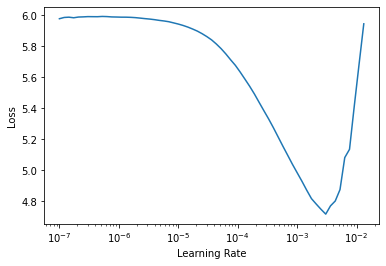

In [24]:
learn.lr_find()

In [25]:
learn.fit_one_cycle(10, 5e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.664050,2.448932,0.291979,11.575982,00:52
1,2.392892,2.296475,0.323603,9.939082,00:52
2,2.081407,1.967721,0.413562,7.154351,00:53
3,1.840996,1.730670,0.479094,5.644434,00:52
4,1.680720,1.590114,0.517587,4.904309,00:52
5,1.577062,1.494395,0.542974,4.456641,00:52
6,1.513004,1.442760,0.555405,4.232361,00:52
7,1.467104,1.397796,0.567296,4.046273,00:52
8,1.441014,1.378166,0.573796,3.967617,00:53
9,1.429312,1.374274,0.574683,3.952205,00:52


In [25]:
learn.save('shakespeare_e10')

Path('models/shakespeare_e10.pth')

In [ ]:
# learn.load('shakespeare_e10')

## Init experiments 

[pytorch init docs](https://pytorch.org/docs/stable/nn.init.html?highlight=xavier_unifor#torch.nn.init.xavier_uniform_)

TODOs: 
- [ ] rerun experiments with latest changes for fair comparison
- [ ] checkout ativation stats using https://docs.fast.ai/callback.hook.html#ActivationStats
- [ ] try combining different init's with different positional encodings

In [ ]:
# for n, m in learn.model.named_modules():
#     print(n)
#     print(m)

### default + fixed pos encodings

In [74]:
learn = Learner(dls, TransformerLM(vocab_sz, 512, pos_enc='fixed'),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(lr_min=0.00014454397605732084, lr_steep=0.0003311311302240938)

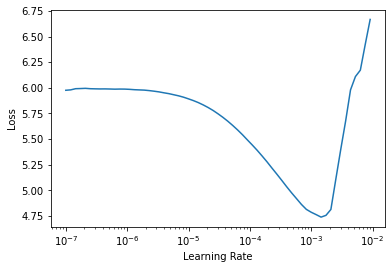

In [75]:
learn.lr_find()

In [76]:
learn.fit_one_cycle(10, 4e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,2.743430,2.444108,0.292617,11.520267,00:53
1,2.398844,2.335627,0.314304,10.335935,00:53
2,2.163848,2.066226,0.388265,7.894975,00:53
3,1.958189,1.846298,0.449932,6.336320,00:53
4,1.819980,1.719737,0.482581,5.583058,00:53
5,1.724584,1.633556,0.503539,5.122058,00:52
6,1.667275,1.580653,0.520047,4.858126,00:53
7,1.626676,1.550155,0.527804,4.712202,00:52
8,1.608951,1.534863,0.532722,4.640691,00:52
9,1.599010,1.531286,0.533108,4.624121,00:52


### bert init

In [27]:
learn = Learner(dls, TransformerLM(vocab_sz, 512),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()]).to_fp16()

In [51]:
def print_parameter_stats(model):
    for n, m in model.named_modules():
        if hasattr(m, 'weight'):
            print(n)
            print(f'    weights mean {m.weight.mean().item():.6f}, std {m.weight.std().item():.6f}')
        # else:
        #     print(n, ' has no weight')

In [45]:
print_parameter_stats(learn.model)

emb.emb
weights mean 0.000032, std 0.019960
emb.pos_enc.emb
weights mean -0.001253, std 1.003188
tfmr.layers.0.attn.fn.fn.to_q
weights mean 0.000067, std 0.025527
tfmr.layers.0.attn.fn.fn.to_kv
weights mean 0.000070, std 0.025502
tfmr.layers.0.attn.fn.fn.to_out
weights mean 0.000022, std 0.025491
tfmr.layers.0.attn.fn.norm
weights mean 1.000000, std 0.000000
tfmr.layers.0.ff.fn.fn.net.0
weights mean -0.000014, std 0.025508
tfmr.layers.0.ff.fn.fn.net.3
weights mean 0.000002, std 0.012760
tfmr.layers.0.ff.fn.norm
weights mean 1.000000, std 0.000000
tfmr.layers.1.attn.fn.fn.to_q
weights mean -0.000007, std 0.025495
tfmr.layers.1.attn.fn.fn.to_kv
weights mean 0.000008, std 0.025507
tfmr.layers.1.attn.fn.fn.to_out
weights mean 0.000057, std 0.025494
tfmr.layers.1.attn.fn.norm
weights mean 1.000000, std 0.000000
tfmr.layers.1.ff.fn.fn.net.0
weights mean 0.000017, std 0.025520
tfmr.layers.1.ff.fn.fn.net.3
weights mean 0.000024, std 0.012760
tfmr.layers.1.ff.fn.norm
weights mean 1.000000, std 

In [39]:
def bert_init(model):
    """ Initialize the weights """
    for module in model.modules():
        if isinstance(module, (nn.Linear, nn.Embedding)):
            # Slightly different from the TF version which uses truncated_normal for initialization
            # cf https://github.com/pytorch/pytorch/pull/5617
            module.weight.data.normal_(mean=0.0, std=0.02)
        # default to pytorch, to remove
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

In [46]:
bert_init(learn.model)
print_parameter_stats(learn.model)

emb.emb
weights mean -0.000016, std 0.020013
emb.pos_enc.emb
weights mean 0.000007, std 0.019987
tfmr.layers.0.attn.fn.fn.to_q
weights mean 0.000022, std 0.020013
tfmr.layers.0.attn.fn.fn.to_kv
weights mean 0.000039, std 0.020014
tfmr.layers.0.attn.fn.fn.to_out
weights mean -0.000020, std 0.020039
tfmr.layers.0.attn.fn.norm
weights mean 1.000000, std 0.000000
tfmr.layers.0.ff.fn.fn.net.0
weights mean 0.000019, std 0.019999
tfmr.layers.0.ff.fn.fn.net.3
weights mean -0.000015, std 0.019989
tfmr.layers.0.ff.fn.norm
weights mean 1.000000, std 0.000000
tfmr.layers.1.attn.fn.fn.to_q
weights mean 0.000069, std 0.020000
tfmr.layers.1.attn.fn.fn.to_kv
weights mean 0.000057, std 0.019997
tfmr.layers.1.attn.fn.fn.to_out
weights mean 0.000091, std 0.020047
tfmr.layers.1.attn.fn.norm
weights mean 1.000000, std 0.000000
tfmr.layers.1.ff.fn.fn.net.0
weights mean -0.000014, std 0.019979
tfmr.layers.1.ff.fn.fn.net.3
weights mean -0.000028, std 0.020000
tfmr.layers.1.ff.fn.norm
weights mean 1.000000, st

SuggestedLRs(lr_min=0.00010000000474974513, lr_steep=7.585775892948732e-05)

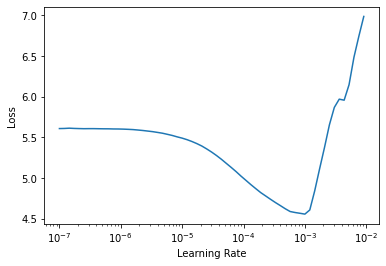

In [47]:
learn.lr_find()

In [48]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.001231,2.584840,0.282925,13.261165,00:52
1,2.434564,2.346462,0.314638,10.448535,00:52
2,2.338681,2.281197,0.332321,9.788386,00:52
3,2.261158,2.167946,0.359999,8.740310,00:53
4,2.157986,2.058212,0.389097,7.831952,00:52
5,2.065553,1.964524,0.412205,7.131520,00:52
6,1.997321,1.898286,0.430962,6.674441,00:52
7,1.952435,1.861121,0.443805,6.430941,00:52
8,1.932240,1.838866,0.449773,6.289404,00:52
9,1.923388,1.834828,0.451060,6.264058,00:53


In [49]:
learn.save('bert_init_10e')

Path('models/bert_init_10e.pth')

### xavier init everywhere

In [52]:
learn = Learner(dls, TransformerLM(vocab_sz, 512),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()]).to_fp16()

In [54]:
def xavier_init(model):
    """ Initialize the weights """
    for module in model.modules():
        if isinstance(module, (nn.Linear, nn.Embedding)):
            
            nn.init.xavier_uniform_(module.weight)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

In [55]:
xavier_init(learn.model)
print_parameter_stats(learn.model)

emb.emb
    weights mean 0.000264, std 0.051040
emb.pos_enc.emb
    weights mean 0.000104, std 0.044180
tfmr.layers.0.attn.fn.fn.to_q
    weights mean -0.000026, std 0.044152
tfmr.layers.0.attn.fn.fn.to_kv
    weights mean -0.000055, std 0.036080
tfmr.layers.0.attn.fn.fn.to_out
    weights mean 0.000034, std 0.044259
tfmr.layers.0.attn.fn.norm
    weights mean 1.000000, std 0.000000
tfmr.layers.0.ff.fn.fn.net.0
    weights mean -0.000035, std 0.027973
tfmr.layers.0.ff.fn.fn.net.3
    weights mean -0.000028, std 0.027958
tfmr.layers.0.ff.fn.norm
    weights mean 1.000000, std 0.000000
tfmr.layers.1.attn.fn.fn.to_q
    weights mean -0.000024, std 0.044245
tfmr.layers.1.attn.fn.fn.to_kv
    weights mean 0.000044, std 0.036081
tfmr.layers.1.attn.fn.fn.to_out
    weights mean 0.000047, std 0.044232
tfmr.layers.1.attn.fn.norm
    weights mean 1.000000, std 0.000000
tfmr.layers.1.ff.fn.fn.net.0
    weights mean 0.000016, std 0.027952
tfmr.layers.1.ff.fn.fn.net.3
    weights mean 0.000030, std

SuggestedLRs(lr_min=3.981071640737355e-05, lr_steep=8.31763736641733e-06)

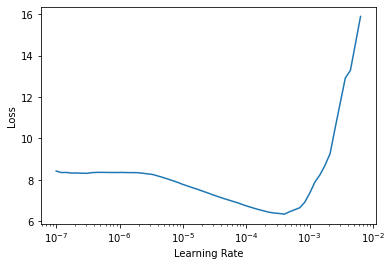

In [56]:
learn.lr_find()

In [57]:
learn.fit_one_cycle(10, 1e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.382634,2.833284,0.256758,17.001196,00:52
1,2.657138,2.470089,0.282285,11.823496,00:52
2,2.488379,2.387735,0.290666,10.888807,00:53
3,2.401469,2.329479,0.318252,10.272586,00:52
4,2.323820,2.230975,0.342784,9.308942,00:52
5,2.238005,2.145386,0.367885,8.545335,00:52
6,2.171559,2.066600,0.390477,7.897922,00:52
7,2.126211,2.025503,0.400875,7.579920,00:52
8,2.099094,2.004403,0.405491,7.421661,00:53
9,2.092339,1.998510,0.407279,7.378053,00:52
